# Experiment 3: Solving equations on a weighted projective space

We generate a system of polynomial equations that have solutions of large modulus. Many solvers prematurely truncate these paths and do not compute these solutions. These equations homogenize to equations on a weighted projective space, where we compute all solutions.

We activate the project's environment.

In [1]:
using Pkg
Pkg.activate(".")

 Activating environment at `~/Documents/Projects/cox-homotopies/code_cox_homotopies_fix/Project.toml`


We include our methods below.

In [2]:
include("CoxHomotopy.jl")

polymake version 4.2
Copyright (c) 1997-2020
Ewgenij Gawrilow, Michael Joswig, and the polymake team
Technische Universität Berlin, Germany
https://polymake.org

This is free software licensed under GPL; see the source for copying conditions.
There is NO warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



trackPathRandom (generic function with 1 method)

The following code generates a system that homogenizes to a weighted projective space of the specified weights.

This first block generates the polytope corresponding to our weighted projective space.

In [3]:
weights = [1 2 2 2 4];
n = length(weights);
verts = zeros(Int64,n,n+1);
for i = 1:n
    verts[i,i] = lcm(weights)/weights[i]
end
P = convexHull(3*verts);
Fᵀ,a = facetRepresentation(P);

polymake: used package ppl
  The Parma Polyhedra Library ([[wiki:external_software#PPL]]): A C++ library for convex polyhedra
  and other numerical abstractions.
  http://www.cs.unipr.it/ppl/



We create a degenerate system $\hat{f}$ below. The degeneracy comes from solutions lying on the intersection of divisors $D_5\cap D_6$.

In [4]:
k = n+1;
@polyvar x[1:k] t[1:n];
latpts = getLatticePoints(P,x);
mons = [prod(t.^latpts[ℓ,:]) for ℓ=1:size(latpts,1)];

M5 = (Fᵀ[5,:]'*latpts')[:];
M6 = (Fᵀ[6,:]'*latpts')[:];
indsmonsonF5 = findall(ℓ -> ℓ == minimum(M5), M5);
indsmonsonF6 = findall(ℓ -> ℓ == minimum(M6), M6);
indsmonsonF56 = intersect(indsmonsonF5,indsmonsonF6);
indsmonsnotonF56 = setdiff(1:length(mons),indsmonsonF56);
g = convert(Array{ComplexF64},rand(1:10,length(indsmonsonF56)))'*mons[indsmonsonF56];
f̂ = [convert(Array{ComplexF64},rand(1:10,length(mons)))'*mons for ℓ=1:n-3];
f̂ = vcat([g + convert(Array{ComplexF64},rand(1:10,length(indsmonsnotonF56)))'*mons[indsmonsnotonF56] for i = 1:3],f̂);

We perturb the degenerate system $\hat{f}$ to move all solutions to the torus. 

In [5]:
ε = 1e-7
for i = 1:3
    f̂[i] = f̂[i] + ε*exp.(randn(length(mons))*im)'*mons
end

We solve the system using the Cox homotopy.

In [6]:
@time homSols, f, toricSols, homTargetResult = coxHomotopy(f̂, P, Fᵀ, a);

Tracking 7776 paths... 100%|████████████████████████████| Time: 0:05:19
  # paths tracked:                  7776
  # non-singular solutions (real):  7776 (0)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         7776 (0)
1332.423907 seconds (263.71 M allocations: 22.131 GiB, 0.75% gc time)


polymake: used package cdd
  cddlib
  Implementation of the double description method of Motzkin et al.
  Copyright by Komei Fukuda.
  http://www-oldurls.inf.ethz.ch/personal/fukudak/cdd_home/



Here's a plot of the magnitude of the computed solutions.

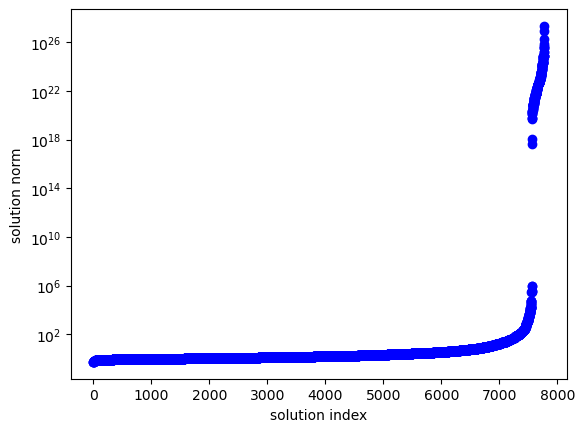

In [7]:
using PyPlot
maxcoords = [maximum(abs.(sol)) for sol ∈ toricSols]
semilogy(sort(maxcoords),"bo")
xlabel("solution index");
ylabel("solution norm");

All computed solutions (including the large ones) have a small backward error. 

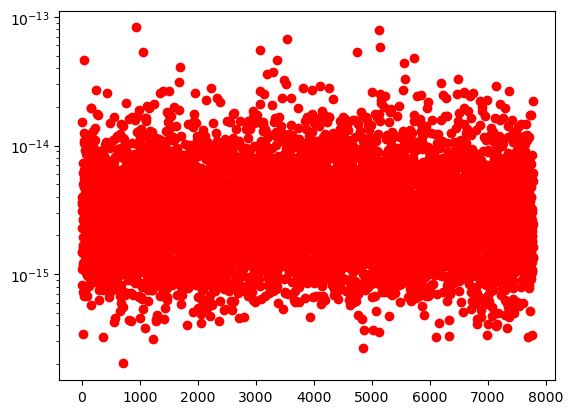

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1777fe610>

In [8]:
residuals = get_residual(f̂,toricSols,t)
semilogy(residuals,"ro")

Due to premature truncation of seemingly diverging paths, the standard polyhedral homotopy misses about 200 solutions.

In [9]:
solve(f̂)

Tracking 7776 paths... 100%|████████████████████████████| Time: 0:04:05
  # paths tracked:                  7776
  # non-singular solutions (real):  7561 (24)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         7561 (24)


Result with 7561 solutions
• 7776 paths tracked
• 7561 non-singular solutions (24 real)
• random_seed: 0xf28bb5a0
• start_system: :polyhedral


In [10]:
length(findall(r->r<1e-10,residuals))

7776

In [ ]:
nruns = 10
nsols_HC_list = []
for ℓ = 4:16
    resℓ = []
    for s = 1:nruns
        k = n+1;
        @polyvar x[1:k] t[1:n];
        latpts = getLatticePoints(P,x);
        mons = [prod(t.^latpts[ℓ,:]) for ℓ=1:size(latpts,1)];

        M5 = (Fᵀ[5,:]'*latpts')[:];
        M6 = (Fᵀ[6,:]'*latpts')[:];
        indsmonsonF5 = findall(ℓ -> ℓ == minimum(M5), M5);
        indsmonsonF6 = findall(ℓ -> ℓ == minimum(M6), M6);
        indsmonsonF56 = intersect(indsmonsonF5,indsmonsonF6);
        indsmonsnotonF56 = setdiff(1:length(mons),indsmonsonF56);
        g = convert(Array{ComplexF64},rand(1:10,length(indsmonsonF56)))'*mons[indsmonsonF56];
        f̂ = [convert(Array{ComplexF64},rand(1:10,length(mons)))'*mons for ℓ=1:n-3];
        f̂ = vcat([g + convert(Array{ComplexF64},rand(1:10,length(indsmonsnotonF56)))'*mons[indsmonsnotonF56] for i = 1:3],f̂);
        ε = 10.0^(-ℓ)
        for i = 1:3
            f̂[i] = f̂[i] + ε*exp.(randn(length(mons))*im)'*mons
        end
        #@time homSols, f, toricSols, homTargetResult = coxHomotopy(f̂, P, Fᵀ, a);
        R = solve(f̂)
        residuals_HC = get_residual(f̂,solutions(R),t)
        nsols_HC = length(findall(r->r<1e-10,residuals_HC))
        push!(resℓ,nsols_HC)
    end
    push!(nsols_HC_list,sum(nsols_HC)/nruns)
end
nsols_HC_list

Tracking 7776 paths...  10%|██▉                         |  ETA: 0:03:38
  # paths tracked:                  813
  # non-singular solutions (real):  812 (0)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         812 (0)